# Decision Trees and Random Forests: Application on feature data for HeLa cell line in GREG.

Shaurya Jauhari (Email: shauryajauhari@gzhmu.edu.cn)

## Contents

* [1. Decision Trees](#link1)
    * [1.1 Package Installation and Loading Libraries](#link2)
    * [1.2 Dataset Handling](#link3)
    * [1.3 Deploying Tree Models](#link4)
        * [1.3.1 'party' Package](#link5)
            * [1.3.1.1 SMOTE Transformation](#link6)
        * [1.3.2 'rpart' Package](#link7)
* [2. Random Forests](#link8)
    * [2.1  Core (randomForest)](#link9)
* [3. Visualizing Predictions](#link10)
* [4. Session Information](#link11)

##  <a id=link1>1. Decision Trees </a>

### <a id=link2>1.1 Package Installation and Loading Libraries </a>

In [1]:
requiredPackages <- c("party", "rpart", "rpart.plot", "ROSE", "DMwR", "randomForest")
newPackages <- requiredPackages[!(requiredPackages %in% installed.packages()[,"Package"])]
if(length(newPackages)) install.packages(newPackages,
                                         repos = "https://mirrors.tuna.tsinghua.edu.cn/CRAN/",
                                         dependencies = TRUE)

library(party)
library(rpart)
library(rpart.plot)
library(DMwR)
library(randomForest)
library(ROSE)

Loading required package: grid

Loading required package: mvtnorm

Loading required package: modeltools

Loading required package: stats4

Loading required package: strucchange

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: sandwich

Loading required package: lattice

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.

Loaded ROSE 0.0-3




### <a id=link3>1.2 Dataset Handling </a>

In [2]:
helagregStandard <- read.table("../data/HeLaforML.txt", header = TRUE) ## loading data
helagreg <- helagregStandard[, -c(1:3)] ## removing the first three columns for non-usage in the ML model.

In [3]:
head(helagreg)

,CTCF,EP300,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K9ac,H3K9me3,RAD21,RNA.Seq,RNAPol2,RNAPol3,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,0.00000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.00000000,0.00000000,0,0.000000,0.00000000,Non-Hub
2,0.00000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.00000000,0.00000000,0,0.000000,0.00000000,Non-Hub
3,0.00000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.00000000,0.00000000,0,0.000000,0.00000000,Non-Hub
4,0.00000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.00000000,0.00000000,0,0.000000,0.00000000,Non-Hub
5,0.00000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.000000,0.00000000,0.00000000,0,0.000000,0.07964071,Non-Hub
6,16.31532,0.3485739,0.7310137,0.5121474,0.2671445,0.9937343,0.8823614,1.233227,0.03706458,0.08740367,0,1.506197,13.00798194,Non-Hub


In [4]:
rownames(helagreg) <- c()
helagreg$Class <- as.numeric(as.factor(helagreg$Class))-1
head(helagreg$Class)

[1] 1 1 1 1 1 1

### <a id=link4>1.3 Deploying Tree Models </a>

#### <a id=link5>1.3.1 'party' Package </a>

Let us now partition the data into training and testing subsets, as per the Pareto's dogma, i.e. maintaining 80:20 ratio for train and testing cases.

In [5]:
set.seed(3)
dataPartition <- sample(2, nrow(helagreg), replace = TRUE, prob = c(0.8,0.2))
train <- helagreg[dataPartition==1,]
test <- helagreg[dataPartition==2,]

In [6]:
cat("We have",nrow(train),"training examples and",nrow(test),"for testing.")

We have 1214551 training examples and 304375 for testing.

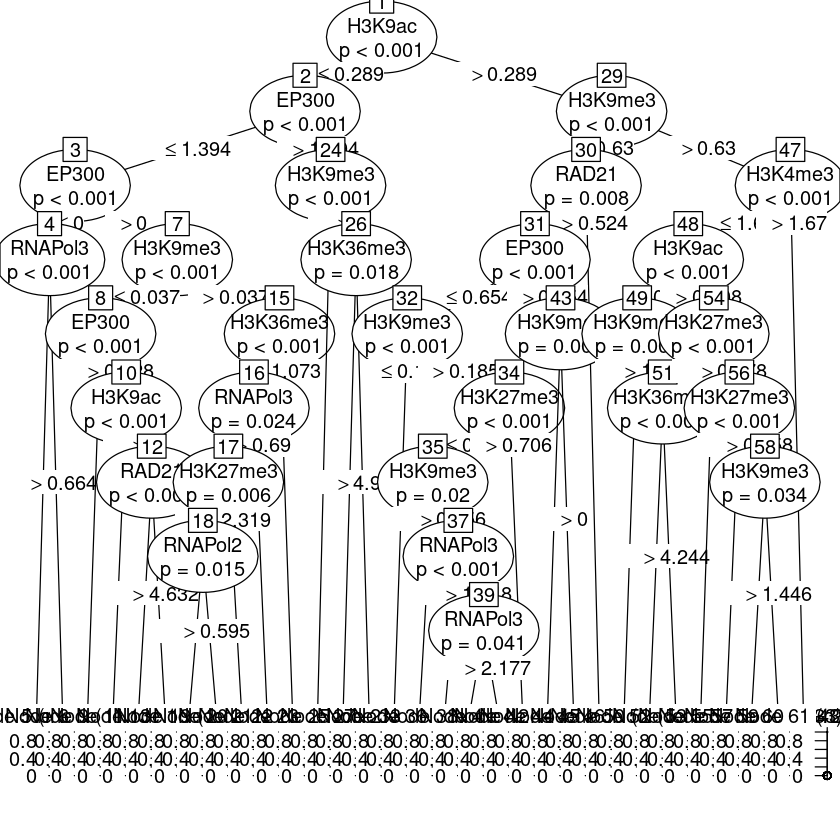

In [7]:
helaTree <- ctree(Class ~ ., data= train)
plot(helaTree)

The summary says that the tree has 61 overall nodes.

In [8]:
source("../R/modelPerformance.R")
modelPerformance(helaTree, "rf", test, Class)

Loading required package: ggplot2


Attaching package: ‘ggplot2’


The following object is masked from ‘package:randomForest’:

    margin




The confusion matrix is
         Actual
Predicted      0      1
        0    464 303911
The accuracy of the model is 0.1524435 % 
The misclassification error of the model is 99.84756 % 


[1] "Only a single class predicted. Probably skewed data handling."

In [9]:
treePred <- predict(helaTree,test)
head(ifelse(treePred > 0.5, "Non-Hub", "Hub"))
treePred <- ifelse(treePred > 0.5, "1", "0")

Class
Non-Hub
Non-Hub
Non-Hub
Non-Hub
Non-Hub
Non-Hub


In [10]:
treePredProb <- predict(helaTree,test, type="prob")
head(treePredProb)

[[1]]
[1] 1

[[2]]
[1] 0.9988801

[[3]]
[1] 0.9988801

[[4]]
[1] 0.9988801

[[5]]
[1] 0.9988801

[[6]]
[1] 0.9988801

It can be articulated that the high skewness in data towards "Non-Hubs" outnumbering "Hubs" has engenedered a high-probability of classification for the former and "Hubs" haven't been predicted at all. 

Let us examine if the bifurcation of data into 7:3 ratio of training and testing sets makes any difference in the structure of the classification tree here.

In [11]:
set.seed(03)
dataPartition73 <- sample(2, nrow(helagreg), replace = TRUE, prob = c(0.7,0.3))
train73 <- helagreg[dataPartition73==1,]
test73 <- helagreg[dataPartition73==2,]

In [12]:
cat("We have",nrow(train73),"training examples and",nrow(test73),"for testing.")

We have 1062981 training examples and 455945 for testing.

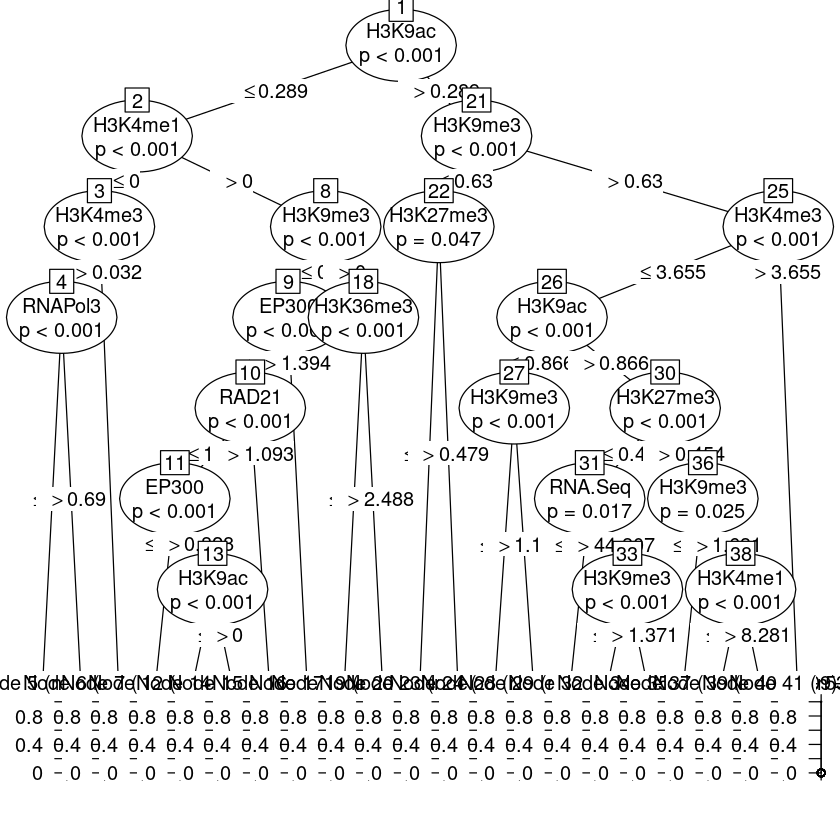

In [13]:
helaTree73 <- ctree(Class ~ ., data= train73)
plot(helaTree73)

In [14]:
treePred73 <- predict(helaTree73, test73, type="response")
treePred73 <- ifelse(treePred73 > 0.5, "1", "0")

In [15]:
modelPerformance(helaTree73, "rf", test73, Class)

The confusion matrix is
         Actual
Predicted      0      1
        0    711 455234
The accuracy of the model is 0.1559399 % 
The misclassification error of the model is 99.84406 % 


[1] "Only a single class predicted. Probably skewed data handling."

No luck here too. The data is highly biased, even for the modified data split. Let's resort to SMOTE transformation.

##### <a id=link6>1.3.1.1 SMOTE Transformation </a>

SMOTE transformation of the data has engendered fair model performance, in the case of logistic regression. See the pipeline [here](https://nbviewer.jupyter.org/github/shauryajauhari/transcriptionFactoriesGREG/blob/master/MachineLearning/LogisticRegressionA549GREG.ipynb).

In [16]:
train$Class <- as.factor(train$Class)
set.seed(77)
smoteData <- SMOTE(Class ~., train, perc.over = 1000, k = 5, perc.under = 110)
table(smoteData$Class)


    0     1 
20262 20262 

Now that the data is seemingly balanced, let's examine the performance of the model.

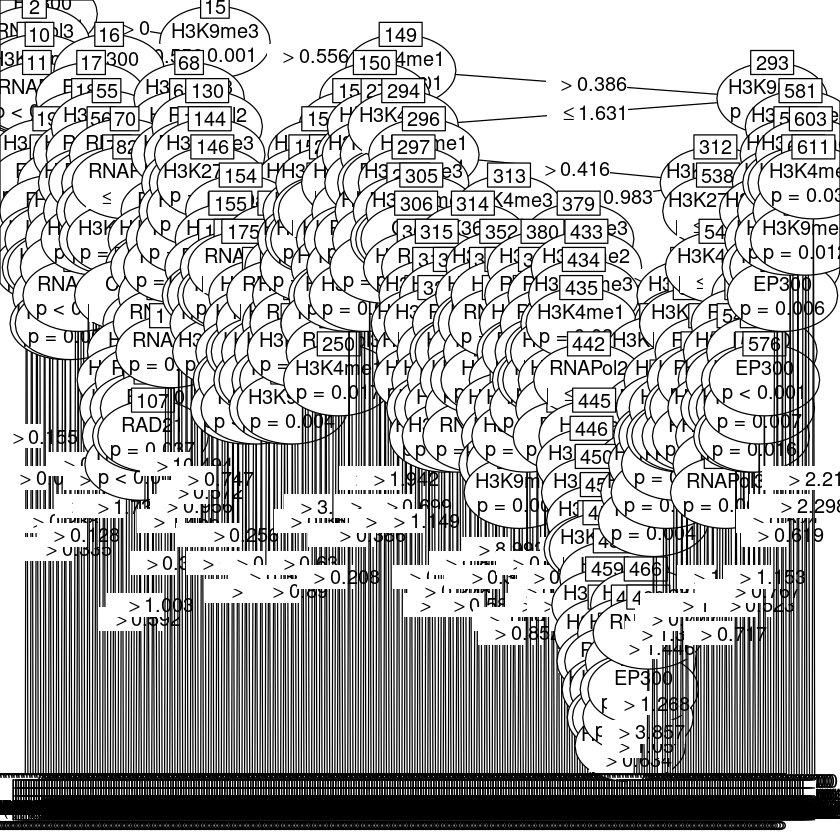

In [17]:
helaSmoteTree <- ctree(Class ~ ., data= smoteData)
plot(helaSmoteTree)

Apparently, the stablization of the class distribution in the data has made the tree more comprehensive. 

Obviously, it is hard to interpret the graphic above.

In [18]:
treeSmotePred <- predict(helaSmoteTree, test)
head(treeSmotePred)

[1] 1 1 1 1 1 1
Levels: 0 1

The confusion matrix is
         Actual
Predicted      0      1
        0    302  97067
        1    162 206844
The accuracy of the model is 68.05618 % 
The misclassification error of the model is 31.94382 % 
The sensitivity of the model is 65.08621 % 
The specificity of the model is 68.06072 % 
The area under curve is 0.6657346 



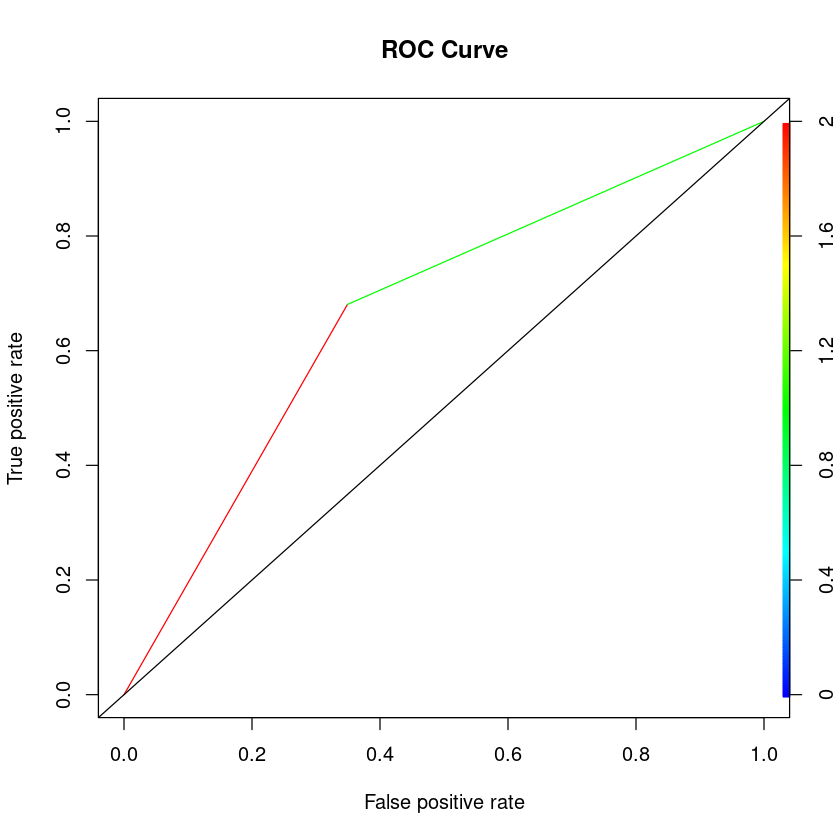

In [19]:
modelPerformance(helaSmoteTree, "rf", test, Class)

We can see distinct class indulgences, as opposed to the above cases of just "Non-Hub" instances.

The AUC and accuracy are pretty darn fair. Also, a notable observation is that the sensitivity and specificity are well balanced. Maybe, we should explore other options.

Addtionally, the function ctree() offers flexibility in terms of defining parameters for classification via ctree_control() function. Look for attributes *mincriterion* and *minsplit*. The former denotes the confidence level (i.e. 1- probability value), while the latter signifies the minimum number of samples required for splitting a tree branch into two. The default values are 0.95 and 20 respectively. Let us examine if any alteration makes a difference.They can be accessed via *controls*, i.e. ctree(formula,data,controls=ctree_control(mincriterion= , minsplit= ).


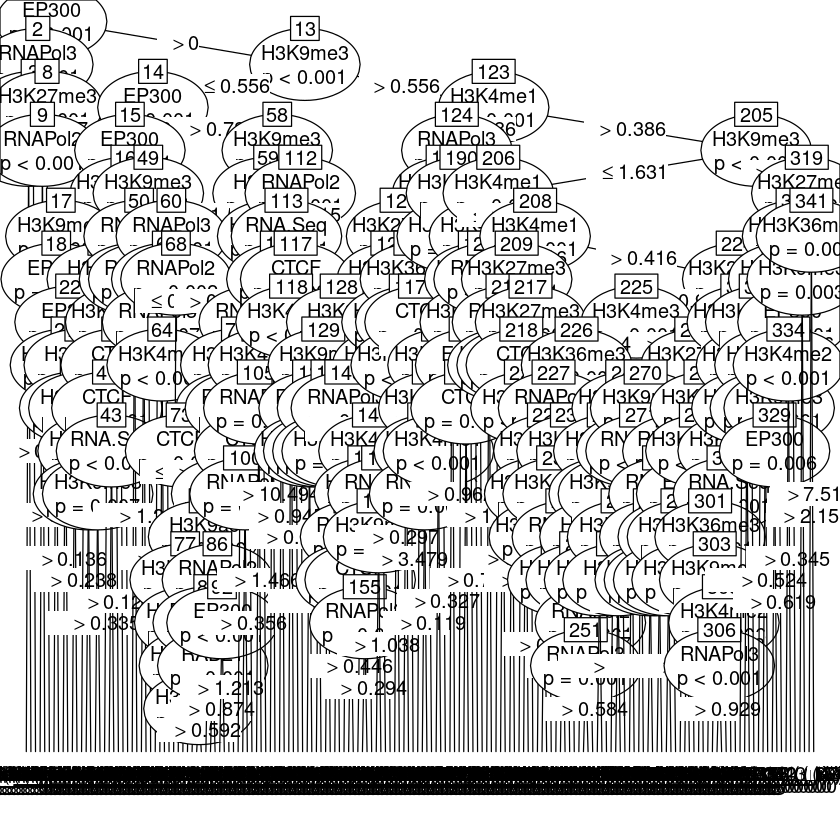

In [20]:
helaSmoteTreeAlt <- ctree(Class ~ ., data= smoteData, controls=ctree_control(mincriterion = .99, minsplit= 10))
plot(helaSmoteTreeAlt)

This tree has relatively lesser number of nodes as more stringent criteria have been imposed. Let us work out the performance metrics for this classification model for the test data.

The confusion matrix is
         Actual
Predicted      0      1
        0    342 117585
        1    122 186326
The accuracy of the model is 61.3283 % 
The misclassification error of the model is 38.6717 % 
The sensitivity of the model is 73.7069 % 
The specificity of the model is 61.3094 % 
The area under curve is 0.6750815 



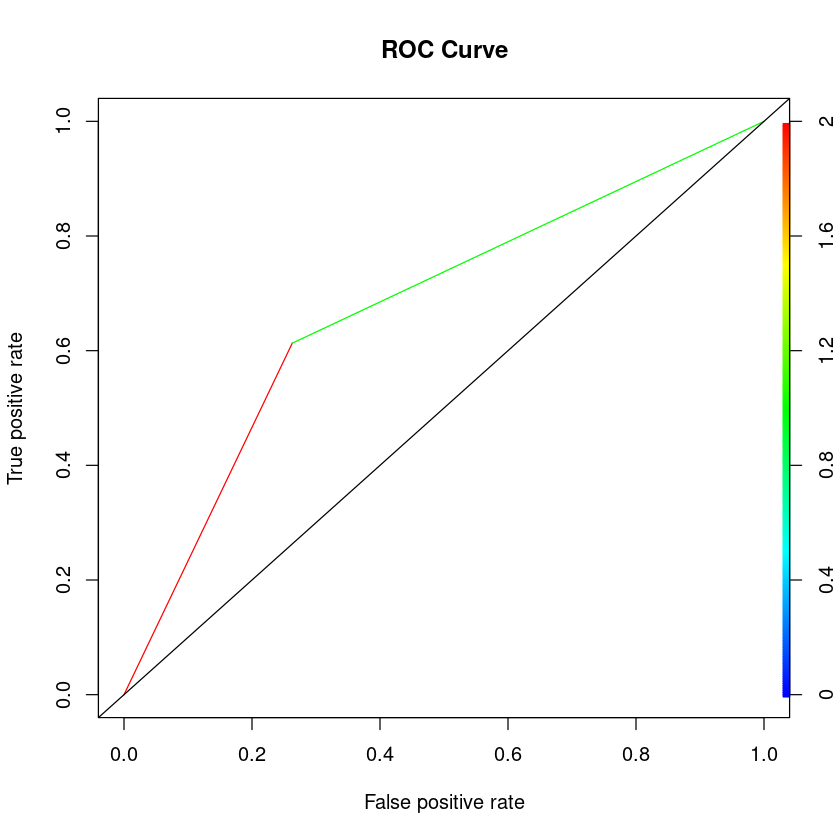

In [21]:
modelPerformance(helaSmoteTreeAlt, "RF", test, Class)

We are assuming "Hub" as a demarcation for the positive class, and so sensitivity of the model being still lower than the specificity establishes that the model is more comprehensible for the "Non-Hub" (negative class). This can again be attributed to the share of data for the respective classes. Ideally, both values be as high in magnitude, is reminiscent of a good model.  

This model is rated lesser in terms of accuracy than the previous model, and the AUC has grown infinitesimally.

#### <a id=link7>1.3.2 'rpart' Package </a>

Using another package, we shall continue to work on the SMOTE transformed training data to model the classifier.

In [22]:
helaTreeAlt <- rpart(Class ~ ., data = smoteData)

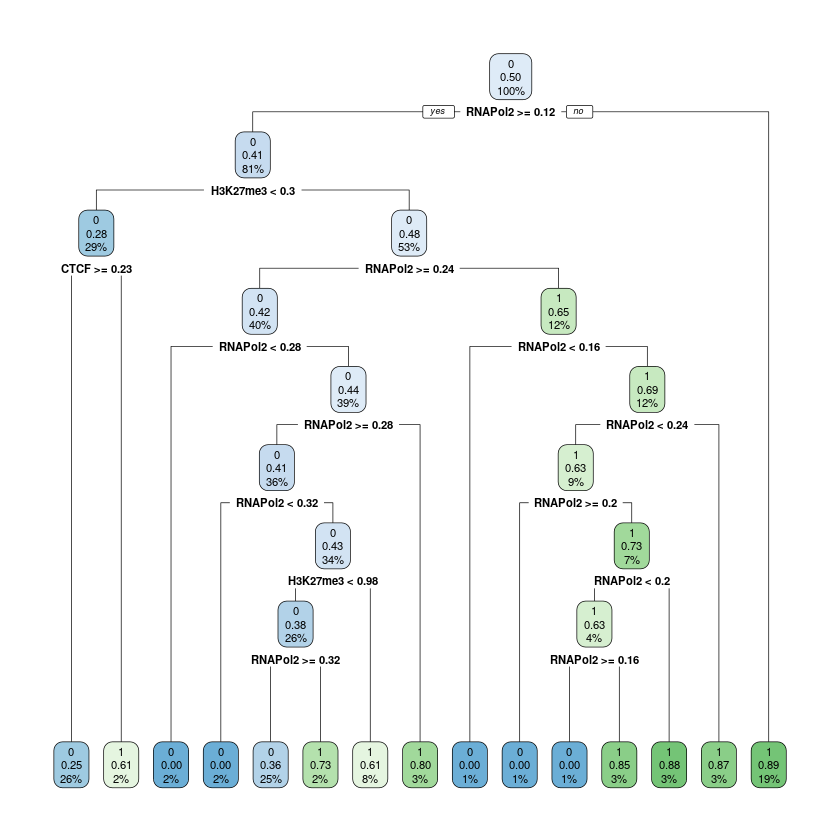

In [23]:
rpart.plot(helaTreeAlt)

There is a complete contrast between the two trees drawn from *ctree()* and *rpart()* functions. The *ctree* uses a significance test procedure in order to select variables instead of selecting the variable that maximizes an information measure (e.g. Gini coefficient). Basically the methodology of both approaches is different; *rpart* is a CART algorithm, while *party* is a CHAID algorithm. (http://www.bzst.com/2006/10/classification-trees-cart-vs-chaid.html).

Next, we move to the more fuller concept, of Random Forests.

##  <a id=link8>2. Random Forests </a>

Decision trees are accomodated inside Random Forests. This ensemble brings about variety in data classification and hence more robustness. This notion also helps in avoidance of overfitting. Random forests can deal with large number of features and selects them for constructing trees on the basis of importance. As we will see, they are easy to implement and have two free parameters to tune- (i) *ntree* signifying the number of trees (where default value is 500), and (ii) *mtry* denoting variables randomly selected for each split (default here sq(p) when classification is sought, and (p/3) when regression; p is the total number of features in the dataset) 

###  <a id=link9>2.1 Core (randomForest) </a>

There are basically three steps involved in construction of a Random Forest:
    1. Draw *ntree* bootstrap samples.
    2. For each bootstrap sample, grow a un-pruned tree by choosing best split based on a random sample of *mtry* predictors at each node.
    3. Predict new data using majority votes for classification, and average for regression based on *ntree* trees.

For application, we shall consider a subset of the data we used for decision trees. The random forests algorithm tend to consume greater in terms of computational resources.

Moving away from the Pareto's principle, let us work with 70:30 split for training and testing data.

In [24]:
## Let us work with a fraction (10%) of data. The algorithm, given the computational resources, fails in execution for the whole data. 

set.seed(8)
helagregSample <- helagreg[sample(nrow(helagreg), replace=T, size=0.1*nrow(helagreg)),]

## Making thr response variable a 'factor', since we are attempting classification.

helagregSample$Class <- as.factor(helagregSample$Class)

## failing to which a warning is thrown : Warning message in randomForest.default(m, y, ...):
## “The response has five or fewer unique values.  Are you sure you want to do regression?”

dataPartition73 <- sample(2, nrow(helagregSample), replace = TRUE, prob = c(0.7,0.3))

train73 <- helagregSample[dataPartition73 == 1,]
test73 <- helagregSample[dataPartition73 == 2,]

Again, the data being biased towards the negative classes, that far outnumber the instances with positive class, we shall transform the data towards being relatively heterogeneous.

In [25]:
bothTrain <- ovun.sample(Class ~., data = train73, method = "both", p =0.5, seed = 11)$data
table(bothTrain$Class)


    1     0 
52850 53258 

We have regulated the data points on near equal distribution of classes. Let us train the classifier on this data.

In [26]:
# Execute random forest algorithm

helarf <- randomForest(formula = Class ~ ., 
                    data = bothTrain,
                   proximity = FALSE,
                   ntree = 500)
print(helarf)


Call:
 randomForest(formula = Class ~ ., data = bothTrain, proximity = FALSE,      ntree = 500) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 0%
Confusion matrix:
      1     0 class.error
1 52850     0           0
0     0 53258           0


In [27]:
# Prediction and Confusion Matrix

helaPredRF <- predict(helarf,test73)
confusionMatrix(helaPredRF, test73$Class)

Warning message in confusionMatrix.default(helaPredRF, test73$Class):
“Levels are not in the same order for reference and data. Refactoring data to match.”


Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0    14     0
         1    60 45710
                                         
               Accuracy : 0.9987         
                 95% CI : (0.9983, 0.999)
    No Information Rate : 0.9984         
    P-Value [Acc > NIR] : 0.05454        
                                         
                  Kappa : 0.3178         
                                         
 Mcnemar's Test P-Value : 2.599e-14      
                                         
            Sensitivity : 0.1891892      
            Specificity : 1.0000000      
         Pos Pred Value : 1.0000000      
         Neg Pred Value : 0.9986891      
             Prevalence : 0.0016163      
         Detection Rate : 0.0003058      
   Detection Prevalence : 0.0003058      
      Balanced Accuracy : 0.5945946      
                                         
       'Positive' Class : 0              
                                      

Despite the high accuracy of the model at 99.87 %, a suitable prediction-ability for positive class (sensitivity) is quite low as compared to specificity (100 %). 

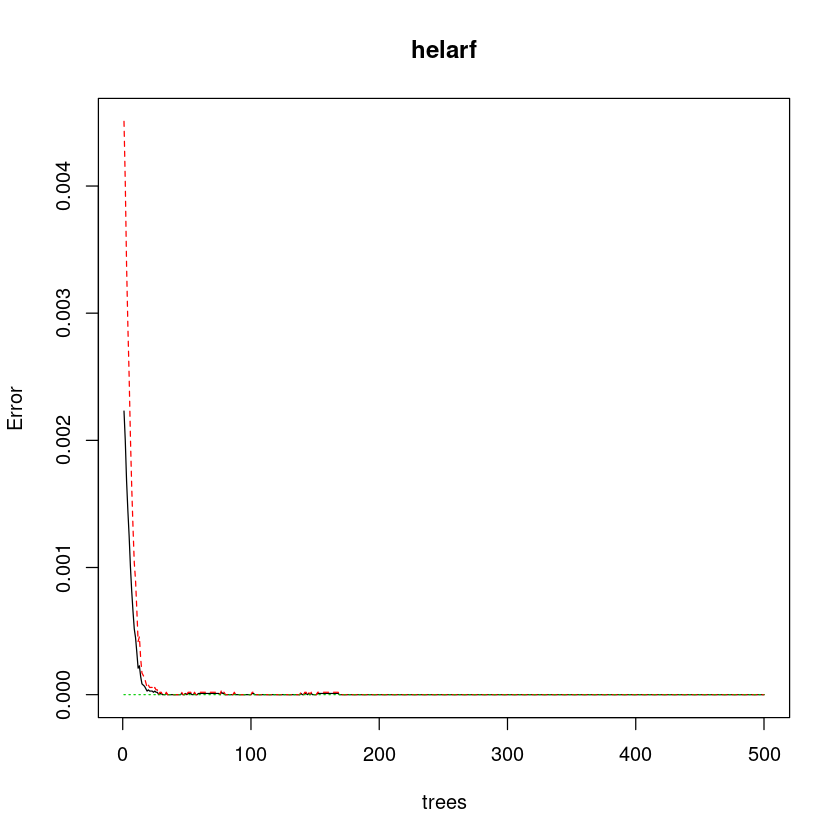

In [28]:
# Error rates (MSEs) of the Random Forest

plot(helarf)

The above plot shows that the error rate stablises after ~ 180 trees and any number of trees beyond doesn't bring any betterment to the error. In view of the same, we shall tune the paramaters of our forest to reduce the number of trees from 500 (default) to 180. Let us observe the change in results. This step helps ascertain an optimal value for *ntree*. 

In [29]:
head(bothTrain)

,CTCF,EP300,H3K27me3,H3K36me3,H3K4me1,H3K4me2,H3K4me3,H3K9ac,H3K9me3,RAD21,RNA.Seq,RNAPol2,RNAPol3,Class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,0.8806567,2.6143044,0.6553916,1.3169506,3.2354165,15.8997480,17.8678190,14.4576160,0.5930333,1.5732660,0.1436135,32.93814039,1.1149699,1
2,0.6720801,0.2614304,1.0335022,0.5365354,0.5046062,0.6246330,0.7878227,1.0233158,1.2972603,0.7429312,0.0000000,0.15854701,0.4512973,1
3,0.8806567,0.7842913,0.6049769,0.7316392,0.3858754,0.8517722,0.6932840,0.4985385,2.1126810,0.6118257,0.0000000,0.15854701,0.5840318,1
4,0.2317518,0.1742870,0.4537327,0.3414316,0.2077790,0.4258861,0.2836162,0.2099109,0.5930333,0.2622110,0.0000000,0.19818376,0.7167664,1
5,0.4403284,0.7842913,0.0000000,0.0000000,0.8014334,0.0000000,0.6302582,0.7609272,0.0000000,0.3933165,0.0000000,0.03963675,0.6636725,1
6,0.2781021,0.4792891,0.6553916,0.7072512,0.2671445,0.5110633,0.2521033,0.3673441,1.0378082,0.3933165,0.0000000,0.07927350,0.5043911,1


mtry = 3  OOB error = 0% 
Searching left ...
mtry = 2 	OOB error = 0% 
-Inf 0.005 
Searching right ...
mtry = 6 	OOB error = 0% 
-Inf 0.005 


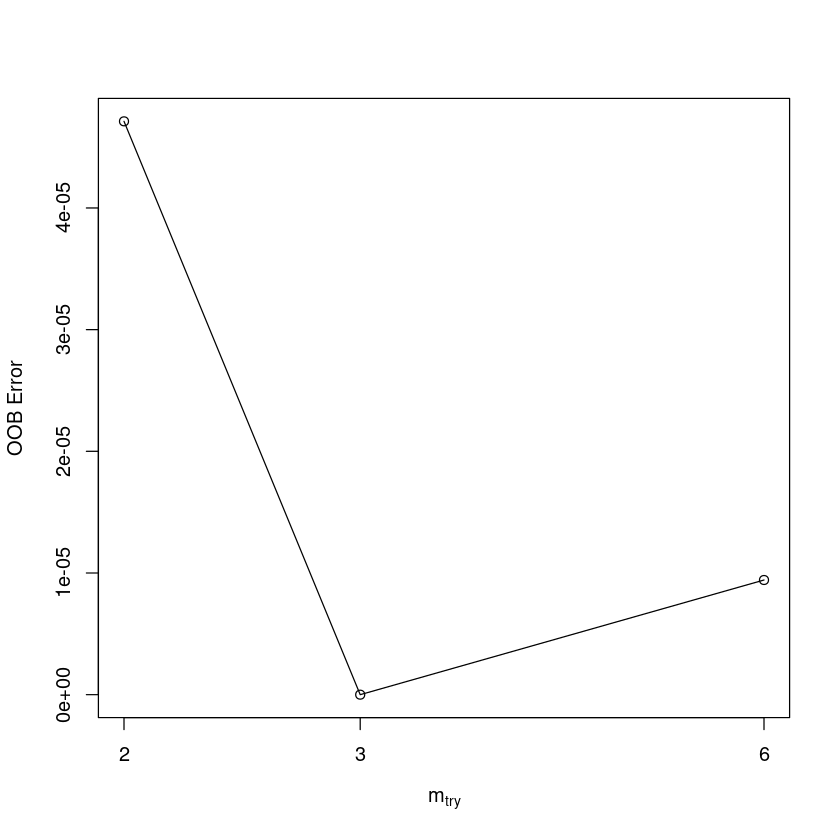

In [30]:
# Tuning mtry

t2 <- tuneRF(bothTrain[,-14], bothTrain[,14],
            stepFactor = 2,
            plot = TRUE,
            ntreeTry = 180,
            trace = TRUE,
            improve = 0.005)               

I think we are good at *mtry* = 2, 3; there is no error.

However, owing to the biasness in the model to predict negative class over positive class, let's make an attempt with *smoteData* flavor and examine any improvement; we did consider balanced samples in *bothTrain* though.

In [32]:
# Execute random forest algorithm

helarf1 <- randomForest(formula = Class ~ ., 
                    data = smoteData,
                   proximity = FALSE,
                   ntree = 180)
print(helarf1)


Call:
 randomForest(formula = Class ~ ., data = smoteData, proximity = FALSE,      ntree = 180) 
               Type of random forest: classification
                     Number of trees: 180
No. of variables tried at each split: 3

        OOB estimate of  error rate: 2.69%
Confusion matrix:
      0     1 class.error
0 19766   496  0.02447932
1   593 19669  0.02926661


The confusion matrix is
         Actual
Predicted      0      1
        0    214   8387
        1    250 295524
The accuracy of the model is 97.16238 % 
The misclassification error of the model is 2.837618 % 
The sensitivity of the model is 46.12069 % 
The specificity of the model is 97.24031 % 
The area under curve is 0.716805 



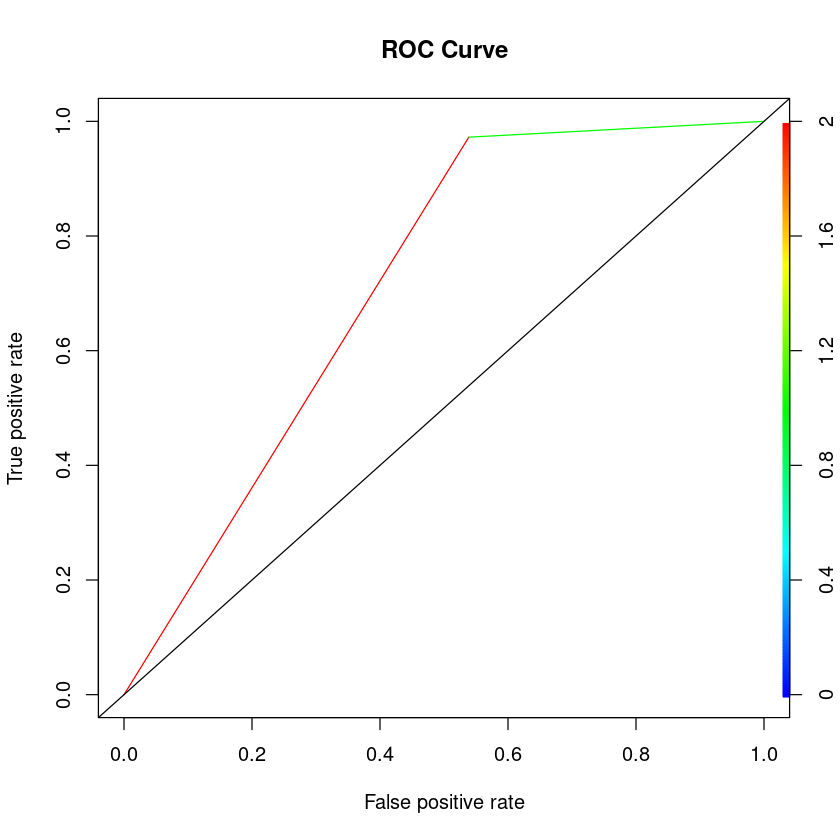

In [33]:
modelPerformance(helarf1, "rf", test, Class)

For sure, this is way better than the previous one, with given improved estimate of sensitivity. We can observe the SMOTE transformation has a positive effect on the model's performance in making predictions for the minority class instances.

In [34]:
helaPredRFOpt <- predict(helarf1,test73)
confusionMatrix(helaPredRFOpt, test73$Class)

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0    65  1286
         1     9 44424
                                          
               Accuracy : 0.9717          
                 95% CI : (0.9702, 0.9732)
    No Information Rate : 0.9984          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0884          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.878378        
            Specificity : 0.971866        
         Pos Pred Value : 0.048113        
         Neg Pred Value : 0.999797        
             Prevalence : 0.001616        
         Detection Rate : 0.001420        
   Detection Prevalence : 0.029508        
      Balanced Accuracy : 0.925122        
                                          
       'Positive' Class : 0               
                  

The model performs well with the 70:30 data in terms of sensitivity and specificity; although for test data the model was low on sensitivity. Regardless, we'll stick to the model.

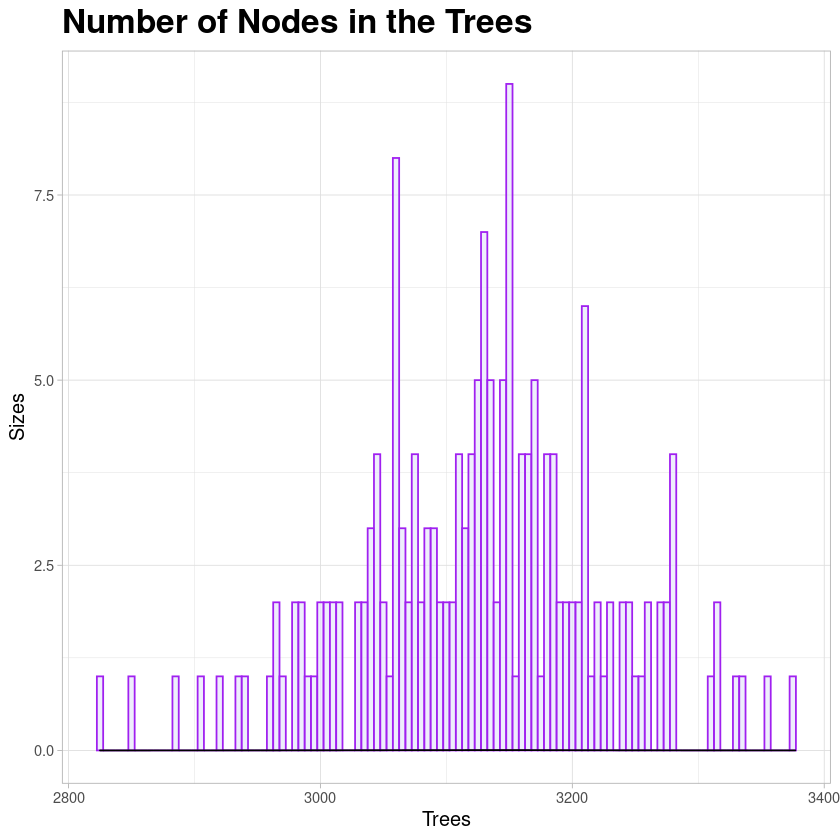

In [35]:
# Number of nodes for the trees
library(ggplot2)
ts <- as.data.frame(treesize(helarf1), row.names = c())
ggplot(data = ts, aes(x = `treesize(helarf1)`)) + 
  geom_histogram(binwidth = 5, color="purple", fill="lavender", position="identity", alpha=0.7)+
  labs(x="Trees", y="Sizes")+
  ggtitle("Number of Nodes in the Trees")+
  geom_density(alpha=0.6)+
  theme_light()+
  theme(plot.title= element_text(size = 20, face = "bold"),
        axis.title = element_text(size = 12))

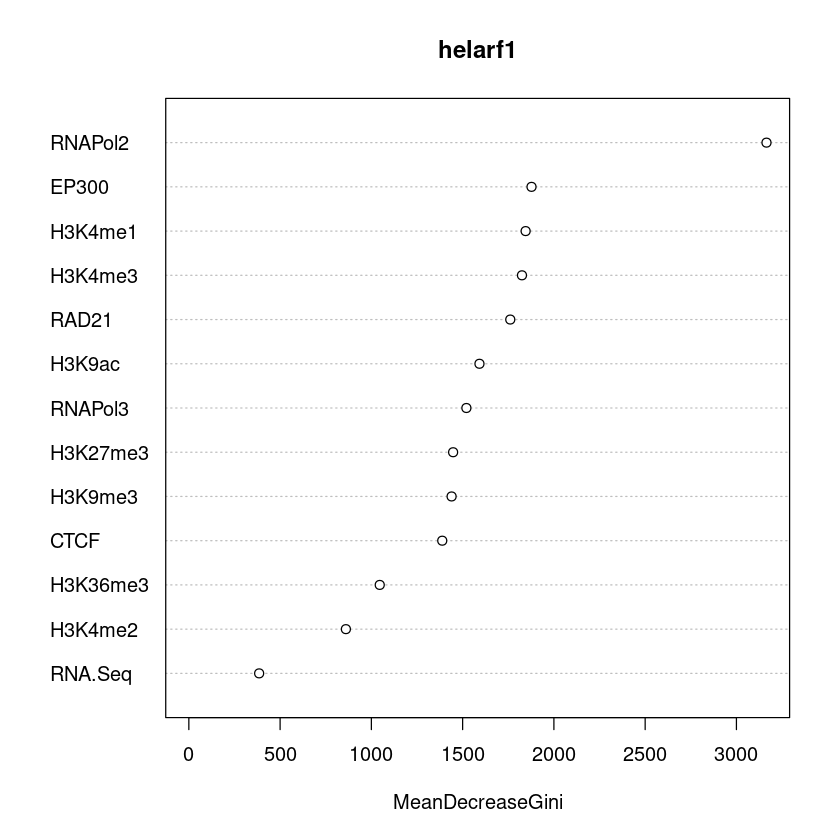

In [36]:
# Variable Importance

varImpPlot(helarf1)

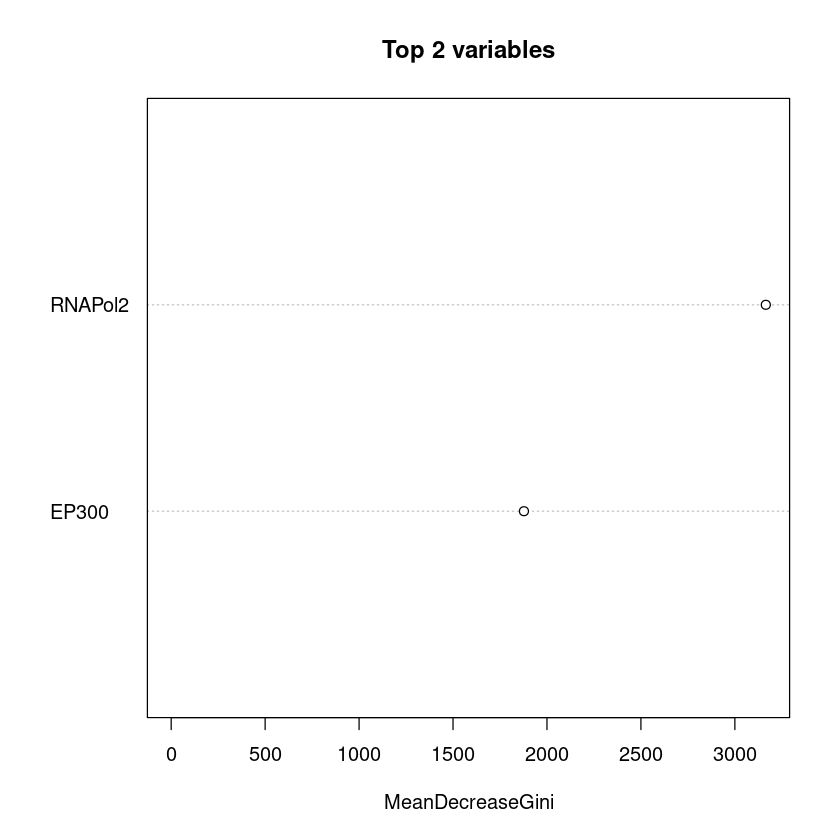

In [37]:
varImpPlot(helarf1 , sort = TRUE, n.var = 2, main = "Top 2 variables")

In [38]:
importance(helarf1)

,MeanDecreaseGini
CTCF,1388.2484
EP300,1877.3884
H3K27me3,1447.8306
H3K36me3,1045.8647
H3K4me1,1845.1288
H3K4me2,860.3969
H3K4me3,1825.0594
H3K9ac,1592.2211
H3K9me3,1439.5478
RAD21,1760.9561


In [39]:
varUsed(helarf1)

[1] 51695 51724 36137 34331 52023 31872 50671 49969 41420 50376  9270 50270
[13] 52654

This classification model of random forests projects **RNAPol2** as the most crucial variable with maximum instances used while contruction of trees.

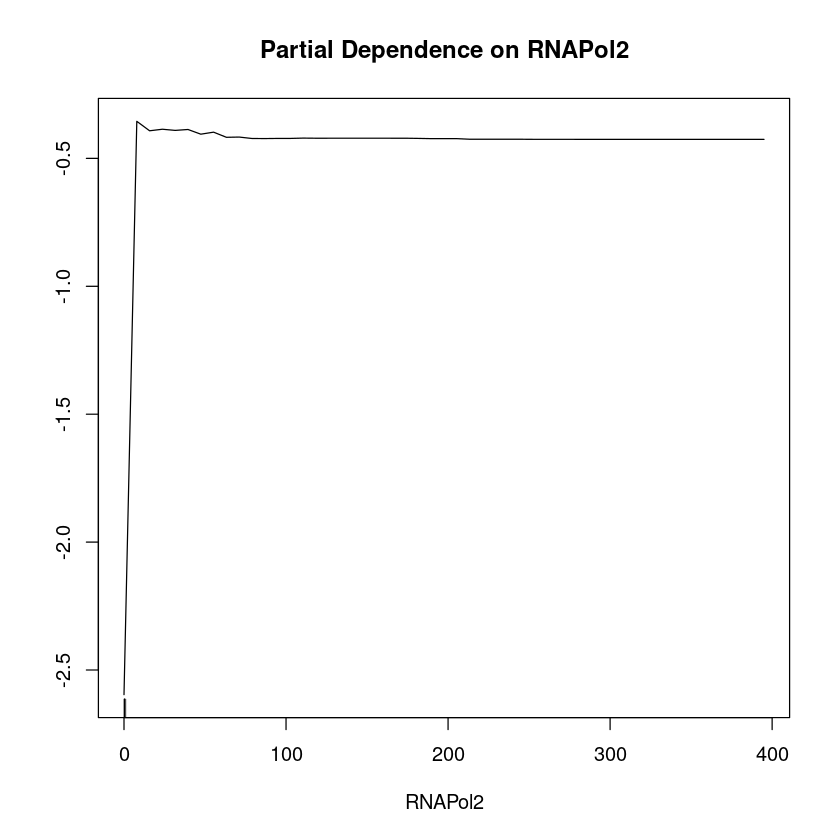

In [40]:
# Partial Dependence Plots

partialPlot(helarf1, smoteData, RNAPol2 , "0")

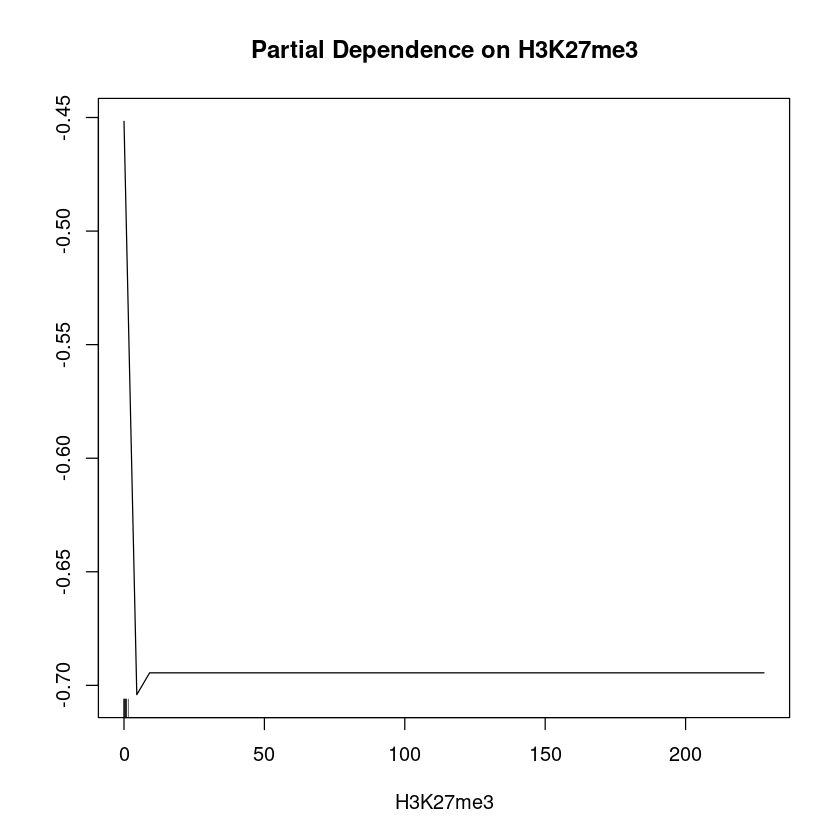

In [41]:
partialPlot(helarf1, smoteData, H3K27me3, "0")

The partial dependence plot represents a variable's contribution to the probability of class depiction (classification). The variable contribution of RNAPol2 is high and regular. Contrarily, as seen above, H3K27me3 has important (stable) contribution to the model but at a much lower scale.

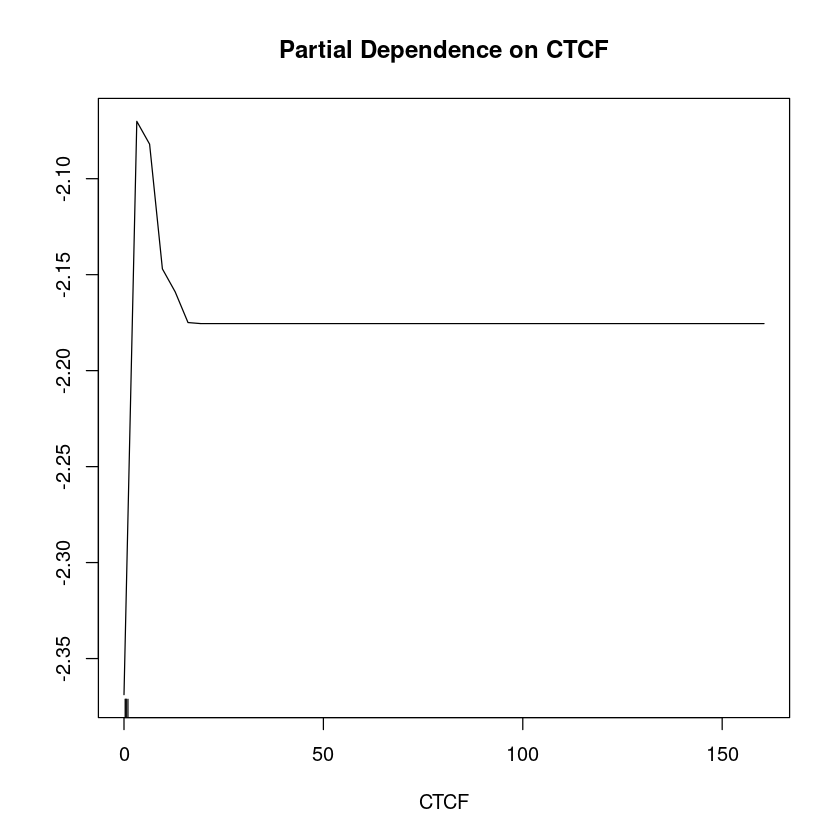

In [42]:
partialPlot(helarf1, smoteData, CTCF, "0")

**CTCF** contributes equally well to the model too.

##  <a id=link10>3. Visualizing Predictions </a>

We choose to go with this model and will save the prediction results, that shall be later utilized for plotting.

In [43]:
helagregModelPredictions <- predict(helarf1, helagreg, type = "response")
helagregModelPredictionsProbs <- as.factor(helagregModelPredictions)

In [44]:
head(helagregModelPredictionsProbs)

1 2 3 4 5 6 
1 1 1 1 1 1 
Levels: 0 1

Eventually, we have the original dataset with the classes and the one with the model predictions. We attempt to map the prediction results corresponding to LR-Hubs from the HeLa cell-line. It will be interesting to see the intersect of the pre-caliberated LR-Hubs and the ones predicted by the classifier.

<a href = "http://www.bioconductor.org/packages/release/bioc/html/Gviz.html" > Gviz </a> is the package we aim to deploy for visualization.

In [45]:
if(!requireNamespace("BiocManager", quietly = TRUE))
BiocManager::install("Gviz")
library(Gviz)

Loading required package: S4Vectors

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following object is masked from ‘package:randomForest’:

    combine


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.mi

Next, we recall the data from the HeLa cell-line (GREG). We already know, this is a comprehensive data (genome-wide) with values corresponding to epigenetic marks (features) for each bin (a 2Kb genomic region), in addition to a "Class", i.e. a "Hub" or a "Non-Hub". For the present case, we shall prune the data for the genomic intervals and their corresponding class. That is all we need! 

In [46]:
helagregStandardRegionsClass <- helagregStandard[, c(1:3,17)]

Also, considering the computational resources we deploy, we shall focus on chromosome 21 only.

In [47]:
head(helagregStandardRegionsClass)

,chr,start,end,Class
,<fct>,<int>,<int>,<fct>
1,chr1,1,2000,Non-Hub
2,chr1,2001,4000,Non-Hub
3,chr1,4001,6000,Non-Hub
4,chr1,6001,8000,Non-Hub
5,chr1,8001,10000,Non-Hub
6,chr1,10001,12000,Non-Hub


In [48]:
## Extracting chr21 data

helagregChr21NonHub <- helagregStandardRegionsClass[helagregStandardRegionsClass$chr=="chr21" & helagregStandardRegionsClass$Class=="Non-Hub", ] ## subset of data for exemplifying
helagregChr21Hub <- helagregStandardRegionsClass[helagregStandardRegionsClass$chr=="chr21" & helagregStandardRegionsClass$Class=="Hub", ]

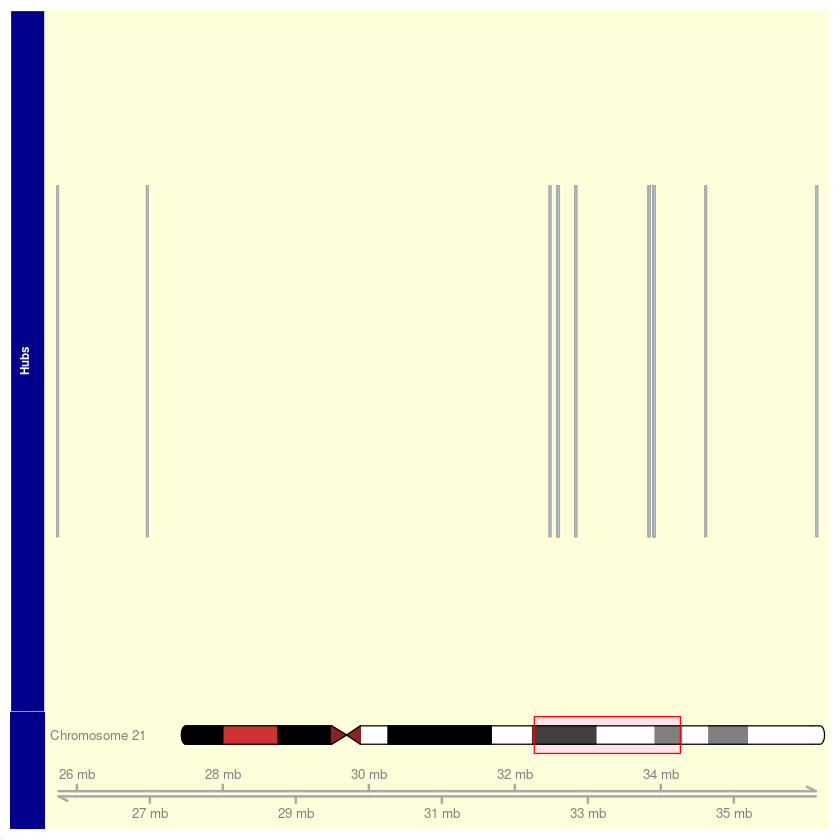

In [49]:
# Plotting Hubs

annotationTrackHub <- AnnotationTrack(range = helagregChr21Hub, 
                                      name = "Hubs", 
                                      genome = "hg38", 
                                      chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
genomeTrack <- GenomeAxisTrack()
plotTracks(list(annotationTrackHub, itrack, genomeTrack), 
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

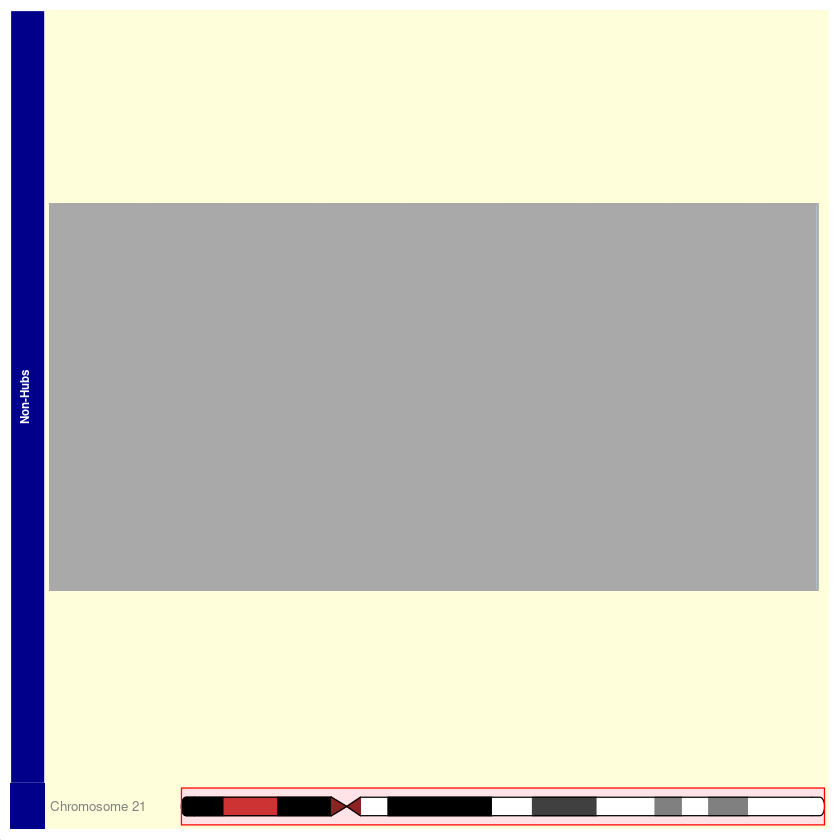

In [50]:
# Plotting Non-Hubs

annotationTrackNonHub <- AnnotationTrack(range = helagregChr21NonHub, 
                                         name = "Non-Hubs", 
                                         genome = "hg38", 
                                         chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
plotTracks(list(annotationTrackNonHub, itrack),
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

We can observe that the Non-Hubs are pretty evenly distributed throughout the chromosome.In contrast, we are curious to examine if the findings of the classifier are able to fortify the original class definitions. Let us frame the data from the predicted results. 

In [51]:
helagregPredicted <- cbind(helagregStandardRegionsClass, helagregModelPredictionsProbs)
names(helagregPredicted)[names(helagregPredicted) == "helagregModelPredictionsProbs"] <- "Prediction"
helagregPredicted$Prediction <- ifelse(helagregPredicted$Prediction == 1, "Non-Hub", "Hub")  

Let us see if the classifier predictions match with the original results.

In [52]:
helagregChr21PredicitedHub <- helagregPredicted[helagregPredicted$chr=="chr21" & helagregPredicted$Prediction =="Hub", ]

Certainly, the predicted hubs are far more in number and there are noticeable instances of "Non-Hubs" that have been classified as "Hubs", with the given profile of the classification model.  

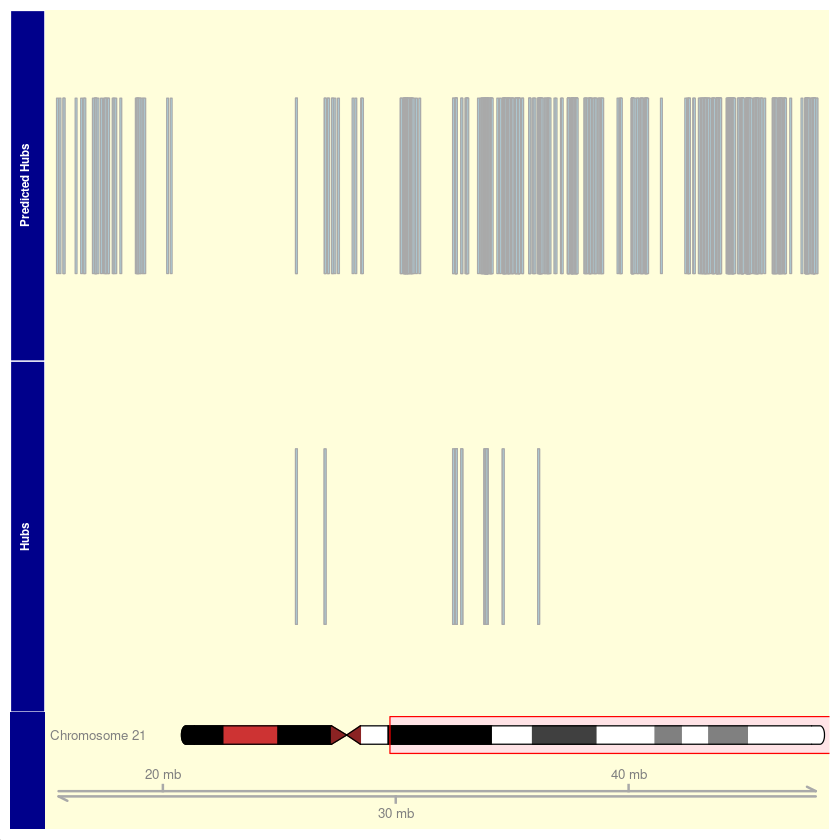

In [53]:
# Plotting Predicted Hubs
annotationTrackHub <- AnnotationTrack(range = helagregChr21Hub, 
                                      name = "Hubs", 
                                      genome = "hg38", 
                                      chromosome = "chr21")
annotationTrackPredictedHub <- AnnotationTrack(range = helagregChr21PredicitedHub, 
                                               name = "Predicted Hubs", 
                                               genome = "hg38", 
                                               chromosome = "chr21")
itrack <- IdeogramTrack(genome = "hg38", chromosome = "chr21")
genomeTrack <- GenomeAxisTrack()
plotTracks(list(annotationTrackPredictedHub,annotationTrackHub, itrack, genomeTrack), 
           background.panel = "#FFFEDB", 
           background.title = "darkblue",
           stacking = "dense")

In [54]:
truePositives <- helagregPredicted[helagregPredicted$Class == helagregPredicted$Prediction, ]

As we close, we'll save the optimal model and true positive genomic regions (hubs) as explicit R data objects, in order to recall for later use.

In [55]:
save(helarf1, file = "../results/optimalModels/helamodelRF")
write.table(truePositives, file = "../results/truePositives/helaRF.txt", quote = FALSE)

##  <a id=link11>4. Session Information </a>

In [70]:
sessionInfo()

R version 3.6.0 (2019-04-26)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/lib64/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] parallel  stats4    grid      stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] Gviz_1.30.3          GenomicRanges_1.38.0 GenomeInfoDb_1.22.1 
 [4] IRanges_2.20.2       S4Vectors_0.24.4     BiocGenerics_0.32.0 
 [7] ROCR_1.0-11          caret_6.0-86         ggplot2_3.3.2       
[10] e1071_1.7-3          ROSE_0.0-3           randomForest_4.6-14 
[13] DMwR_0.4.1           l